In [15]:
import numpy as np
import glob
from astropy.io.fits import getdata, getheader, writeto, append, setval


from os.path import normpath, basename

import matplotlib.pyplot as plt


In [4]:
def load_data_clean(evtdirs, maxload=False):
    # Returns the full mission data unbinned spectrum
    # set divided into epochs along with exposure.
    
    # Setup NuSTAR time epochs:
    launch_met=77241600. # 2012-06-13T00:00:00
    # Quaterly plots
    
    # Set up data structure:
    data_table = {'A':{}, 'B':{}}
    for mod in data_table:
        for det_id in range(4):
            det_key = 'det{}'.format(det_id)
            data_table[mod][det_key] = {'im':np.zeros(32, 32),
                                        'exp':0.}
    
    for ind, evtdir in enumerate(evtdirs):
        for mod in ['A', 'B']:

            seqid = basename(normpath(evtdir))
            
            attorb_file = evtdir+'/'+seqid+'/event_cl/nu'+seqid+'{}.attorb'.format(mod)
            attorb = getdata(attorb_file)

            

            for file in glob.glob('{}/*{}02_cl.evt'.format(evtdir, mod)):
            # Skip these high background obsids
                if file.find("40101012") != -1:
                    continue

                if file.find("30161002002") != -1:
                    continue

                hdr= getheader(file, 1)

                evdata = getdata(file, 1)
                ev_elv = np.interp(evdata['TIME'],attorb['TIME'], attorb['ELV'])
                
                for det_id in range(4):
                    det_key = 'det{}'.format(det_id)
 
                    elec_filter = ~ ( \
                                (evdata['STATUS'][:, 10]) | \
                                (evdata['STATUS'][:, 8]) | \
                                (evdata['STATUS'][:, 7]) | \
                                (evdata['STATUS'][:, 6]) | \
                                (evdata['STATUS'][:, 5]) | \
                                (evdata['STATUS'][:, 4]) ) 

                    evt_filter = (elec_filter) & \
                        (evdata['DET_ID'] == det_id) & \
                        (evdata['GRADE'] == 0) & \
                        (ev_elv < -1)

                    good_inds = np.where(evt_filter)[0]

                    

                    ehist, edges = np.histogram(evdata['PI'][good_inds],
                                        range = [0, 4096],
                                        bins=4096)
                    data_table[mod][det_key]['spec'] += ehist
                    data_table[mod][det_key]['exp'] +=np.float(hdr['EXPOSURE'])

        if (ind % 10) ==0:
            print('{} of {}'.format(ind, len(evtdirs)))

        if maxload is not False:
            if ind > maxload:
                break
    return data_table
    


In [103]:
def write_spec(outspec, exp, outname='draft.pha', det_id=det_id, mod='A'):
    # Read the template
    null, hdr = getdata('nu30001039002_srcA_sr.pha', 0, header=True)
    writeto(outname, null, header=hdr, overwrite=True)
    spec, hdr = getdata('nu30001039002_srcA_sr.pha', 1, header=True)
    spec['COUNTS'] = outspec
    hdr['RESPFILE'] = '{}{}.rmf'.format(det_id, mod)
    hdr['BACKFILE'] = ''
    hdr['ANCRFILE'] = ''
    hdr['EXPOSURE'] = 1.0
    append(outname, spec, hdr)



In [7]:
for epoch_file in sorted(glob.glob('epoch*_list.txt')):
    print(epoch_file)
    epoch = (epoch_file.split('_'))[0]


    evtdirs = np.loadtxt(epoch_file, dtype='str')
    dtab = load_data_clean(evtdirs)
#     for mod in dtab:
#         for det_id in dtab[mod]:
#             outname='{}_{}_FPM{}_repro.pha'.format(epoch, det_id, mod)
#             print(outname)
#             #write_spec(dtab[mod][det_id]['spec'], 
#             #          dtab[mod][det_id]['exp'], det_id = det_id, outname=outname)

    break


epoch1_list.txt
['../scripts/reprocess_background/full_mission/60021110001/'
 '../scripts/reprocess_background/full_mission/80002013026/'
 '../scripts/reprocess_background/full_mission/80002013023/'
 '../scripts/reprocess_background/full_mission/40032008001/'
 '../scripts/reprocess_background/full_mission/60023002001/'
 '../scripts/reprocess_background/full_mission/60061259001/'
 '../scripts/reprocess_background/full_mission/60061324001/'
 '../scripts/reprocess_background/full_mission/60002027004/'
 '../scripts/reprocess_background/full_mission/60061072001/'
 '../scripts/reprocess_background/full_mission/60001068002/']


In [23]:
# Set up data structure:
data_table = {'A':{}, 'B':{}}
for mod in data_table:
    for det_id in range(4):
        det_key = 'det{}'.format(det_id)
        data_table[mod][det_key] = {'det_im':np.zeros([32, 32]),
                                    'exp':0.}

e_cut = 10. # keV
pi_cut = (10.0 - 1.6)/0.04

for ind, evtdir in enumerate(evtdirs):
    for mod in ['A', 'B']:
        print(evtdir)
        for file in glob.glob('{}/*{}02_cl.evt'.format(evtdir, mod)):
            print(file)
        
            evdata = getdata(file, 1)
            
            for det_id in range(4):
                det_key = 'det{}'.format(det_id)

                evt_filter = (evdata['PI'] < pi_cut) & \
                    (evdata['DET_ID'] == det_id)

                det_im, xedges, yedges = np.histogram2d(evdata['RAWX'][evt_filter], evdata['RAWY'][evt_filter],
                                        bins = 32, range = [[0, 31], [0,31]])
                
                data_table[mod][det_key]['det_im'] += det_im
 #               data_table[mod][det_key]['exp'] +=np.float(hdr['EXPOSURE'])
                break


        break
    break


../scripts/reprocess_background/full_mission/60021110001/
../scripts/reprocess_background/full_mission/60021110001/nu60021110001A02_cl.evt


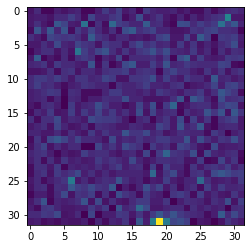

In [25]:
plt.imshow(data_table['A']['det0']['det_im'])
plt.show()